In [1]:
DQN_OFFLINE = True
DQN_ONLINE = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint as pp
import gym

from lstd import LSTDQ, LSTDMu, LSPI
from simulator import Simulator
from policy import *
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.utils import check_random_state

In [4]:
# hypyerparams
gamma= 0.99
s0 = [-0.5, -0.05]

In [5]:
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
pp(env.observation_space.sample())
pp(env.action_space.sample())

array([-0.2121357 ,  0.03012651], dtype=float32)
1


## build basis functions
- linear (3d: pos, velo, action)
- RBFwith 400 components with varying gammas

In [7]:
def get_phi(scaler):
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    phi = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
            ])
    phi.fit(scaler.transform(xs))
    
    def f(s, a):
        sa = np.hstack((s, a))
        if len(sa.shape) == 1:
            sa = np.expand_dims(sa, axis=0)
        x = scaler.transform(sa)
        return phi.transform(x).T
    
    return f

def get_psi(scaler):
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    psi = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
            ])
    psi.fit(scaler.transform(xs))
    
    def f(s, a):
        sa = np.hstack((s, a))
        if len(sa.shape) == 1:
            sa = np.expand_dims(sa, axis=0)
        x = scaler.transform(sa)
        return psi.transform(x).T
    
    return f


# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
states = np.array([env.observation_space.sample() for x in range(10000)])
actions = np.array([env.action_space.sample() for x in range(10000)]).reshape(10000, 1)
xs = np.hstack((states, actions))

print(xs.shape)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(xs)

def simple_phi(s, a):
    # identity
    return np.expand_dims(np.hstack((s, a)), axis=1)

phi_rbf = get_phi(scaler)
psi_rbf = phi_rbf
phi_linear = simple_phi
psi_linear = phi_linear

(10000, 3)


## make behavior policies

In [8]:
import random

In [9]:
# pi_expert


# pi_explore
pi1 = RandomPolicy2(choices=[0]) # left
pi2 = RandomPolicy2(choices=[2]) # right
pi3 = RandomPolicy2(choices=[0, 2]) # left, right

class ManualPolicy():
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
    
class StochasticPolicy():
    def __init__(self):
        self.manual_policy = ManualPolicy()
        self.random_policy = RandomPolicy2(choices=[0, 2]) # left, right

    def choose_action(self, s):
        if random.random() < 0.25:
            return self.random_policy.choose_action(s)
        else:
            return self.manual_policy.choose_action(s)
    
pi4 = ManualPolicy()

# pi_evaluate
pi5 = RandomPolicy2(choices=[0, 1, 2]) # left, right

# for offline dqn
pi6 = StochasticPolicy()

## Train on-policy DQN on Mountaincar

In [10]:
import baselines
from baselines import deepq
import tensorflow as tf

/usr/lib64/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
if DQN_ONLINE:
    # Enabling layer_norm here is import for parameter space noise!
    sess = tf.InteractiveSession()
    tf.reset_default_graph()
    model = deepq.models.mlp([64], layer_norm=True)
    act = deepq.learn(
        env,
        q_func=model,
        lr=1e-3,
        max_timesteps=100000,
        buffer_size=50000,
        exploration_fraction=0.1,
        exploration_final_eps=0.1,
        print_freq=10,
        param_noise=True
    )
    print("Saving model to mountaincar_model.pkl")
    act.save("mountaincar_model.pkl")

In [12]:
# Load from pickle
#act = deepq.load("mountaincar_model.pkl")

In [13]:
# Wrapper so that choose_action is exposed
class Dqn_wrapper(object):
    def __init__(self, act, param_noise = True):
        self.act = act
        self.param_noise = param_noise
    
    def choose_action(self, s):
        if self.param_noise:
            return self.act(s[None], None, None, None)[0]
        else:
            return self.act(s[None])[0]
    

In [14]:
# Instantiate
if DQN_ONLINE:
    pi_dqn = Dqn_wrapper(act)

## generate trajectories under behavior policy (=D)

- behavior policy: optimal (expert) + suboptimal
- right now use only quasi optimal + suboptimal

In [15]:
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

In [16]:
trajs1 = sim.simulate(pi1, n_trial=1, n_episode=50)
trajs2 = sim.simulate(pi2, n_trial=1, n_episode=50)
trajs3 = sim.simulate(pi3, n_trial=1, n_episode=50)
trajs4 = sim.simulate(pi4, n_trial=1, n_episode=50)
if DQN_ONLINE:
    trajs_dqn = sim.simulate(pi_dqn, n_trial=1, n_episode=50)
trajs_stochastic = sim.simulate(pi6, n_trial=1, n_episode=5000)

In [17]:
trajs1[0][0]

Transition(s=array([-0.5796312,  0.       ]), a=0, r=-1.0, s_next=array([-0.58021293, -0.00058173]), done=False)

In [18]:
trajs1[0][0].s

array([-0.5796312,  0.       ])

## Off-policy DQN

In [19]:
import tensorflow as tf

import baselines.common.tf_util as U

from baselines import deepq
from baselines.deepq.replay_buffer import ReplayBuffer
from baselines.deepq.utils import BatchInput

In [35]:
def build_dqn_actor(trajs, observation_space_shape, num_actions, learning_starts = 1000, replay_buffer_size = 32):
        model = deepq.models.mlp([64], layer_norm=True)
        act, train, update_target, debug = deepq.build_train(
            make_obs_ph=lambda name: BatchInput(observation_space_shape, name=name),
            q_func=model,
            num_actions=num_actions,
            optimizer=tf.train.AdamOptimizer(learning_rate=5e-4),
        )
        
        # Create the replay buffer
        replay_buffer = ReplayBuffer(50000)
        
        # Initialize the parameters and copy them to the target network.
        U.initialize()
        update_target()
        
        # Iterate through episodes, adding the data to replay buffer
        t = 0
        e = 0
        for episode in trajs:
            e += 1
            for transition in episode:
                # Log number of transitions processed
                t += 1
                
                # Add transition to replay buffer.
                # print(act(transition.s[None])) # print the action chosen
                replay_buffer.add(transition.s, transition.a, transition.r, transition.s_next, float(transition.done))
                
                # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
                if t > learning_starts:
                    obses_t, actions, rewards, obses_tp1, dones = replay_buffer.sample(replay_buffer_size)
                    td_errors = train(obses_t, actions, rewards, obses_tp1, dones, np.ones_like(rewards))
                
                # Update target network periodically.
                if t % 500 == 0:
                    update_target()
            if e % 1000 == 0:
                print('episode {0}, total transitions processed {1}'.format(e, t))
        update_target()
        return act

In [36]:
if DQN_OFFLINE:
    tf.reset_default_graph()
    off_policy_graph = tf.Graph()
    sess = U.make_session(8, True)
    #sess = tf.Session(graph=off_policy_graph)

In [37]:
if DQN_OFFLINE:
    act_offline = build_dqn_actor(trajs_stochastic, env.observation_space.shape, n_action)

episode 1000, total transitions processed 155757
episode 2000, total transitions processed 311948
episode 3000, total transitions processed 467727
episode 4000, total transitions processed 622934
episode 5000, total transitions processed 778618


In [38]:
act_offline(trajs1[0][0].s[None])

array([1])

In [39]:
if DQN_OFFLINE:
    pi_dqn_offline = Dqn_wrapper(act_offline, param_noise=False)
    # trajs_dqn_offline = sim.simulate(pi_dqn_offline, n_trial=1, n_episode=50)

In [ ]:
if DQN_OFFLINE:
    sess.close()

## Draw trajectories

In [40]:
trajs = trajs1 + trajs2 + trajs3 + trajs4

In [41]:
def draw_traj(traj_, title=None):
    states = []
    actions = []
    rewards = []
    for t in traj_:
        for (s, a, r, s_next, done) in t:
            states.append(s)
            actions.append(a)
            rewards.append(r)

    print(np.sum(np.array(rewards) < 0))
    states = np.array(states)
    sns.set(style='white', palette='Blues')
    ax = plt.gca()

    sc = ax.scatter(states[:,0], states[:,1], c=rewards, alpha=0.3)
    ax.axis([-1.2,0.6,-0.07,0.07])
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    if title:
        ax.set_title(title)
    #plt.colorbar(sc)
    plt.show()
    
    return states, actions, rewards

36829


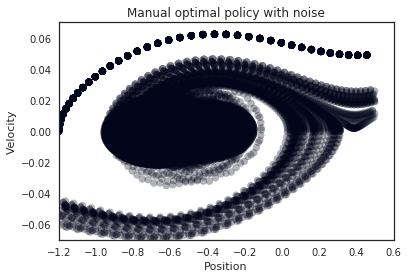

(array([[-0.56598228,  0.        ],
        [-0.56666526, -0.00068298],
        [-0.56802614, -0.00136088],
        ..., 
        [ 0.35873547,  0.0489806 ],
        [ 0.40752939,  0.04879392],
        [ 0.45647027,  0.04894088]]),
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [30]:
draw_traj(trajs, 'Manual optimal policy with noise')

In [31]:
if DQN_ONLINE:
    trajs_dqn = sim.simulate(pi_dqn, n_trial=1, n_episode=500)
    s, a, r = draw_traj(trajs_dqn, 'DQN on-policy')

100000


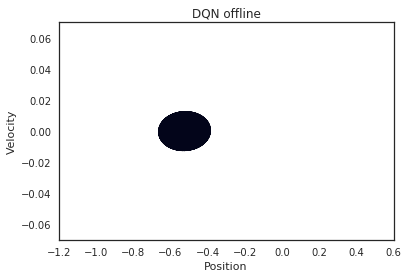

In [42]:
if DQN_OFFLINE:
    trajs_dqn_offline = sim.simulate(pi_dqn_offline, n_trial=1, n_episode=500)
    s, a, r = draw_traj(trajs_dqn_offline, 'DQN offline')

## trajectories under evaluation policy

In [ ]:
trajs5 = sim.simulate(pi5, n_trial=1, n_episode=10)
states = []
actions = []
for t in trajs5:
    for (s, a, r, s_next, done) in t:
        states.append(s)
        actions.append(a)

states = np.array(states)
sns.set(style='white', palette='Blues')
ax = plt.gca()
sc = ax.scatter(states[:,0], states[:,1], c=actions, alpha=0.3)
ax.axis([-1.2,0.6,-0.07,0.07])
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
#plt.colorbar(sc)
plt.show()

## Monte Carlo Mu estimation

In [ ]:
import itertools
def estimate_mu_mc(env, pi, phi, gamma, n_episode):
    mus = []
    ss_init = []
    for epi_i in range(n_episode):
        
        # this is not fixed
        s = env.reset()
        ss_init.append(s)
        mu = 0.0
        for t in itertools.count():
            a = pi.choose_action(s)
            s_next, r, done, _ = env.step(a)
            # todo figure out whether it's phi(s,a) or phi(s)
            mu += gamma ** t * phi(s, a)
            s = s_next
            if done:
                break
        mus.append(mu)
    return mus, ss_init

## MC with linear bassis

In [ ]:
mus_mc_linear, ss_init_linear = estimate_mu_mc(env, pi5, phi_linear, gamma, 1000)
mus_mc_linear = np.array(mus_mc_linear).squeeze()
np.mean(mus_mc_linear, axis=0)

## MC with RBF bassis

In [ ]:
mus_mc_rbf, ss_init_rbf = estimate_mu_mc(env, pi5, phi_rbf, gamma, 1000)
mus_mc_rbf = np.array(mus_mc_rbf).squeeze()
np.mean(mus_mc_rbf, axis=0)

## Visualize Monte Carlo $\mu$ of evaluation policy

- through direct simulation

In [ ]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(mus_mc_rbf).T

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plt.suptitle('Monte Carlo Estimates')

ax1.scatter(mus_mc_linear[:, 0], mus_mc_linear[:, 1])
ax1.set_ylim(-0.02, 0.02)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

# c= ..
ss = ax2.scatter(trans_data[0], trans_data[1], ;
ax2.set_title("t-SNE of mu_expert_stochastic")
ax2.axis('tight')
#fig.colorbar(ss, ax=ax2)
plt.show()
                 
# u_hat= 1/n sum_{i=1}^n (u_i)
# E[u_hat] = u
                 
                 

## LSTD-mu estimation of evaluation policy
- with linear basis
- with rbf basis

In [ ]:
# depends on basis function
p_linear = 3
q_linear = 3
p_rbf = 400
q_rbf = 400
eps = 0.001
lm_linear = LSTDMu(p=p_linear, q=q_linear, phi=phi_linear, psi=psi_linear, gamma=gamma, eps=eps)
lm_rbf = LSTDMu(p=p_rbf, q=q_rbf, phi=phi_rbf, psi=psi_rbf, gamma=gamma, eps=eps)
lm_linear.fit(D=trajs, pi=pi5)
lm_rbf.fit(D=trajs, pi=pi5)

In [ ]:
#pp(np.mean(mus, axis=0))
mus_lstd_linear = []
mus_lstd_rbf = []

for s0 in ss_init:
    # linear
    mu = lm_linear.predict(s0, pi5.choose_action(s0))
    mus_lstd_linear.append(mu)
    # rbf
    mu_rbf = lm_rbf.predict(s0, pi5.choose_action(s0))
    mus_lstd_rbf.append(mu)

mus_lstd_linear = np.array(mus_lstd_linear).squeeze()
mus_lstd_rbf = np.array(mus_lstd_rbf).squeeze()


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plt.suptitle('Distribution of mu expert')

ax1.scatter(mus_lstd_linear[:, 0], mus_lstd_linear[:, 1])
#ax1.set_ylim(-0.02, 0.02)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(mus_lstd_rbf).T

ss = ax2.scatter(trans_data[0], trans_data[1], cmap='Reds')
ax2.set_title("t-SNE of mu_expert_stochastic")
ax2.axis('tight')
#fig.colorbar(ss, ax=[ax1, ax2])
plt.show()

## todo
- get pi expert using LSPI (or DDQN)
- run MMP/AL with LSTD-mu vs. MC-mu

## LSTD-mu
- is this a feature or a bug? (maybe this is just MC variance)
- expert mountain car

## ideas
- directed policy learning with IRL? 

## story
- mlhc: learning accurate reward functions
- ccm: interpretability & decision making

## not markovian?
- use lstm (r_t) + m_t -> phi(r_t, m_t) -> enough data?
- considering history (add temporal component - markovian)
- a strong baseline is to use supervised learning (imitation leanring)

## interpretability
- give pca basis if it makes sense 
- give final weights if it makes sense
- give a trajectory: sample a IRL trajectory (s, a, r, s') see if it makes sense
- check with li-wei


## outline
- raw observations
- discrete-state MDP
    - did not work as well because blah blah
    - bad transition
    - limited state representation
- continuous-state MDP with apprenticeship learning
    - with apprenticeship learning
    
- continuous-state MDP with maximum margin planning
    - shortcoming: no direct control for taking rare actions/rare states
    - suboptimality of expert: introduce slack term
- results
    - mu/v convergence
    - pi matching (metric/trajectory)
    - interpretation of weights, trajectories (how?)

## methods
- mu estimates
- max margin
- ddqn & experience replay


## apply apprenticeship learning

In [ ]:
## value margin

## apply maximum margin planning